In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as msle
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import shap
import warnings
shap.initjs()
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

### lightGBMによる予測（時系列特徴量なし）
CO, C6H6, NOxをそれぞれ個別に予測する

In [2]:
def rmsle(y_true, y_pred):
    
    msle = msle(y_true, y_pred)

    return np.sqrt(msle)

In [3]:
df = pd.read_csv('train_features_added.csv').drop(['month','day','hour','day_of_year', 'day_sin', 'day_cos', 'month_sin', 'month_cos'], axis=1)
df_test = pd.read_csv('test_features_added.csv').drop(['month','day','hour','day_of_year', 'day_sin', 'day_cos', 'month_sin', 'month_cos'], axis=1)

df_scaler = df.copy()
df_test_scaler = df_test.copy()

df_scaler_train, df_scaler_val = train_test_split(df, test_size=0.2, shuffle=False)

def format_date_time(df):

    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

    return df


df_scaler = format_date_time(df_scaler)
df_scaler_train = format_date_time(df_scaler_train)
df_scaler_val = format_date_time(df_scaler_val)
df_test_scaler = format_date_time(df_test_scaler)

df.set_index('date_time', inplace=True)
df_test.set_index('date_time', inplace=True)

In [4]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']

def log_trans(df, features: 'list'):

    for i in features:

        df[i] = np.log1p(df[i])

    return df

df = log_trans(df, targets)

In [5]:
df_train, df_val = train_test_split(df, test_size=0.2, shuffle=False)

categorical_features = ['day_of_week', 'working_hours']

In [6]:
df_val.to_csv('val.csv', index=True)

### Predict CO

In [7]:
train_y_CO = df_train[targets[0]]
train_x_CO = df_train.drop(targets, axis=1)
val_y_CO = df_val[targets[0]]
val_x_CO = df_val.drop(targets, axis=1)

In [8]:

# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_CO, train_y_CO)
    lgb_valids = lgb.Dataset(val_x_CO, val_y_CO)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_CO = regressor.predict(val_x_CO)

    rmsle = np.sqrt(msle(np.expm1(val_y_CO), np.expm1(lgb_pred_val_y_CO).clip(min=0)))
    
    return rmsle

study_CO = optuna.create_study(direction='minimize')
study_CO.optimize(objective, timeout=300)

In [9]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(train_x_CO, train_y_CO)
valids = lgb.Dataset(val_x_CO, val_y_CO)

model_lgb_CO = lgb.train(study_CO.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_CO = model_lgb_CO.predict(val_x_CO)
rmsle_CO = np.sqrt(msle(np.expm1(val_y_CO), np.expm1(val_lgb_CO).clip(min=0)))

lgb_pred_CO = np.expm1(model_lgb_CO.predict(df_test))

rmsle_CO

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3036
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 17
[LightGBM] [Info] Start training from score 1.000200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.20985758009958613

### Predict C6H6

In [10]:
train_y_C6H6 = df_train[targets[1]]
train_x_C6H6 = df_train.drop(targets, axis=1)
val_y_C6H6 = df_val[targets[1]]
val_x_C6H6 = df_val.drop(targets, axis=1)

In [11]:

# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_C6H6, train_y_C6H6)
    lgb_valids = lgb.Dataset(val_x_C6H6, val_y_C6H6)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_C6H6 = regressor.predict(val_x_C6H6)

    rmsle = np.sqrt(msle(np.expm1(val_y_C6H6), np.expm1(lgb_pred_val_y_C6H6).clip(min=0)))
    
    return rmsle

study_C6H6 = optuna.create_study(direction='minimize')
study_C6H6.optimize(objective, timeout=300)

In [12]:
# Oputunaで求めたパラメーターを使い、C6H6の値を予測
trains = lgb.Dataset(train_x_C6H6, train_y_C6H6)
valids = lgb.Dataset(val_x_C6H6, val_y_C6H6)

model_lgb_C6H6 = lgb.train(study_C6H6.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_C6H6 = model_lgb_C6H6.predict(val_x_C6H6)
rmsle_C6H6 = np.sqrt(msle(np.expm1(val_y_C6H6), np.expm1(val_lgb_C6H6).clip(min=0)))

lgb_pred_C6H6 = np.expm1(model_lgb_C6H6.predict(df_test))

rmsle_C6H6

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3036
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 17
[LightGBM] [Info] Start training from score 2.190075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

0.0994559768185634

### Predict NOx

In [13]:
train_y_NOx = df_train[targets[2]]
train_x_NOx = df_train.drop([*targets, 'sensor_2', 'absolute_humidity'], axis=1)
val_y_NOx = df_val[targets[2]]
val_x_NOx = df_val.drop([*targets, 'sensor_2', 'absolute_humidity'], axis=1)

In [14]:

# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_NOx, train_y_NOx)
    lgb_valids = lgb.Dataset(val_x_NOx, val_y_NOx)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_NOx = regressor.predict(val_x_NOx)

    rmsle = np.sqrt(msle(np.expm1(val_y_NOx), np.expm1(lgb_pred_val_y_NOx).clip(min=0)))
    
    return rmsle

study_NOx = optuna.create_study(direction='minimize')
study_NOx.optimize(objective, timeout=300)

In [15]:
# Oputunaで求めたパラメーターを使い、NOxの値を予測
trains = lgb.Dataset(train_x_NOx, train_y_NOx)
valids = lgb.Dataset(val_x_NOx, val_y_NOx)

model_lgb_NOx = lgb.train(study_NOx.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features,
                    )

val_lgb_NOx = model_lgb_NOx.predict(val_x_NOx)
rmsle_NOx = np.sqrt(msle(np.expm1(val_y_NOx), np.expm1(val_lgb_NOx).clip(min=0)))

lgb_pred_NOx = np.expm1(model_lgb_NOx.predict(df_test, predict_disable_shape_check=True))

rmsle_NOx

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2526
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 15
[LightGBM] [Info] Start training from score 4.758380


0.4404015471096638

In [16]:
rmsle_dic =  {'CO':rmsle_CO, 'C6H6':rmsle_C6H6, 'NOx':rmsle_NOx}

print('RMSLE')
print(f'CO: {rmsle_CO}')
print(f'C6H6: {rmsle_C6H6}')
print(f'NOx: {rmsle_NOx}')


RMSLE
CO: 0.20985758009958613
C6H6: 0.0994559768185634
NOx: 0.4404015471096638


In [17]:
test_with_pred = pd.read_csv('test_features_added.csv')

test_with_pred[targets[0]] = lgb_pred_CO
test_with_pred[targets[1]] = lgb_pred_C6H6
test_with_pred[targets[2]] = lgb_pred_NOx

test_with_pred = format_date_time(test_with_pred)


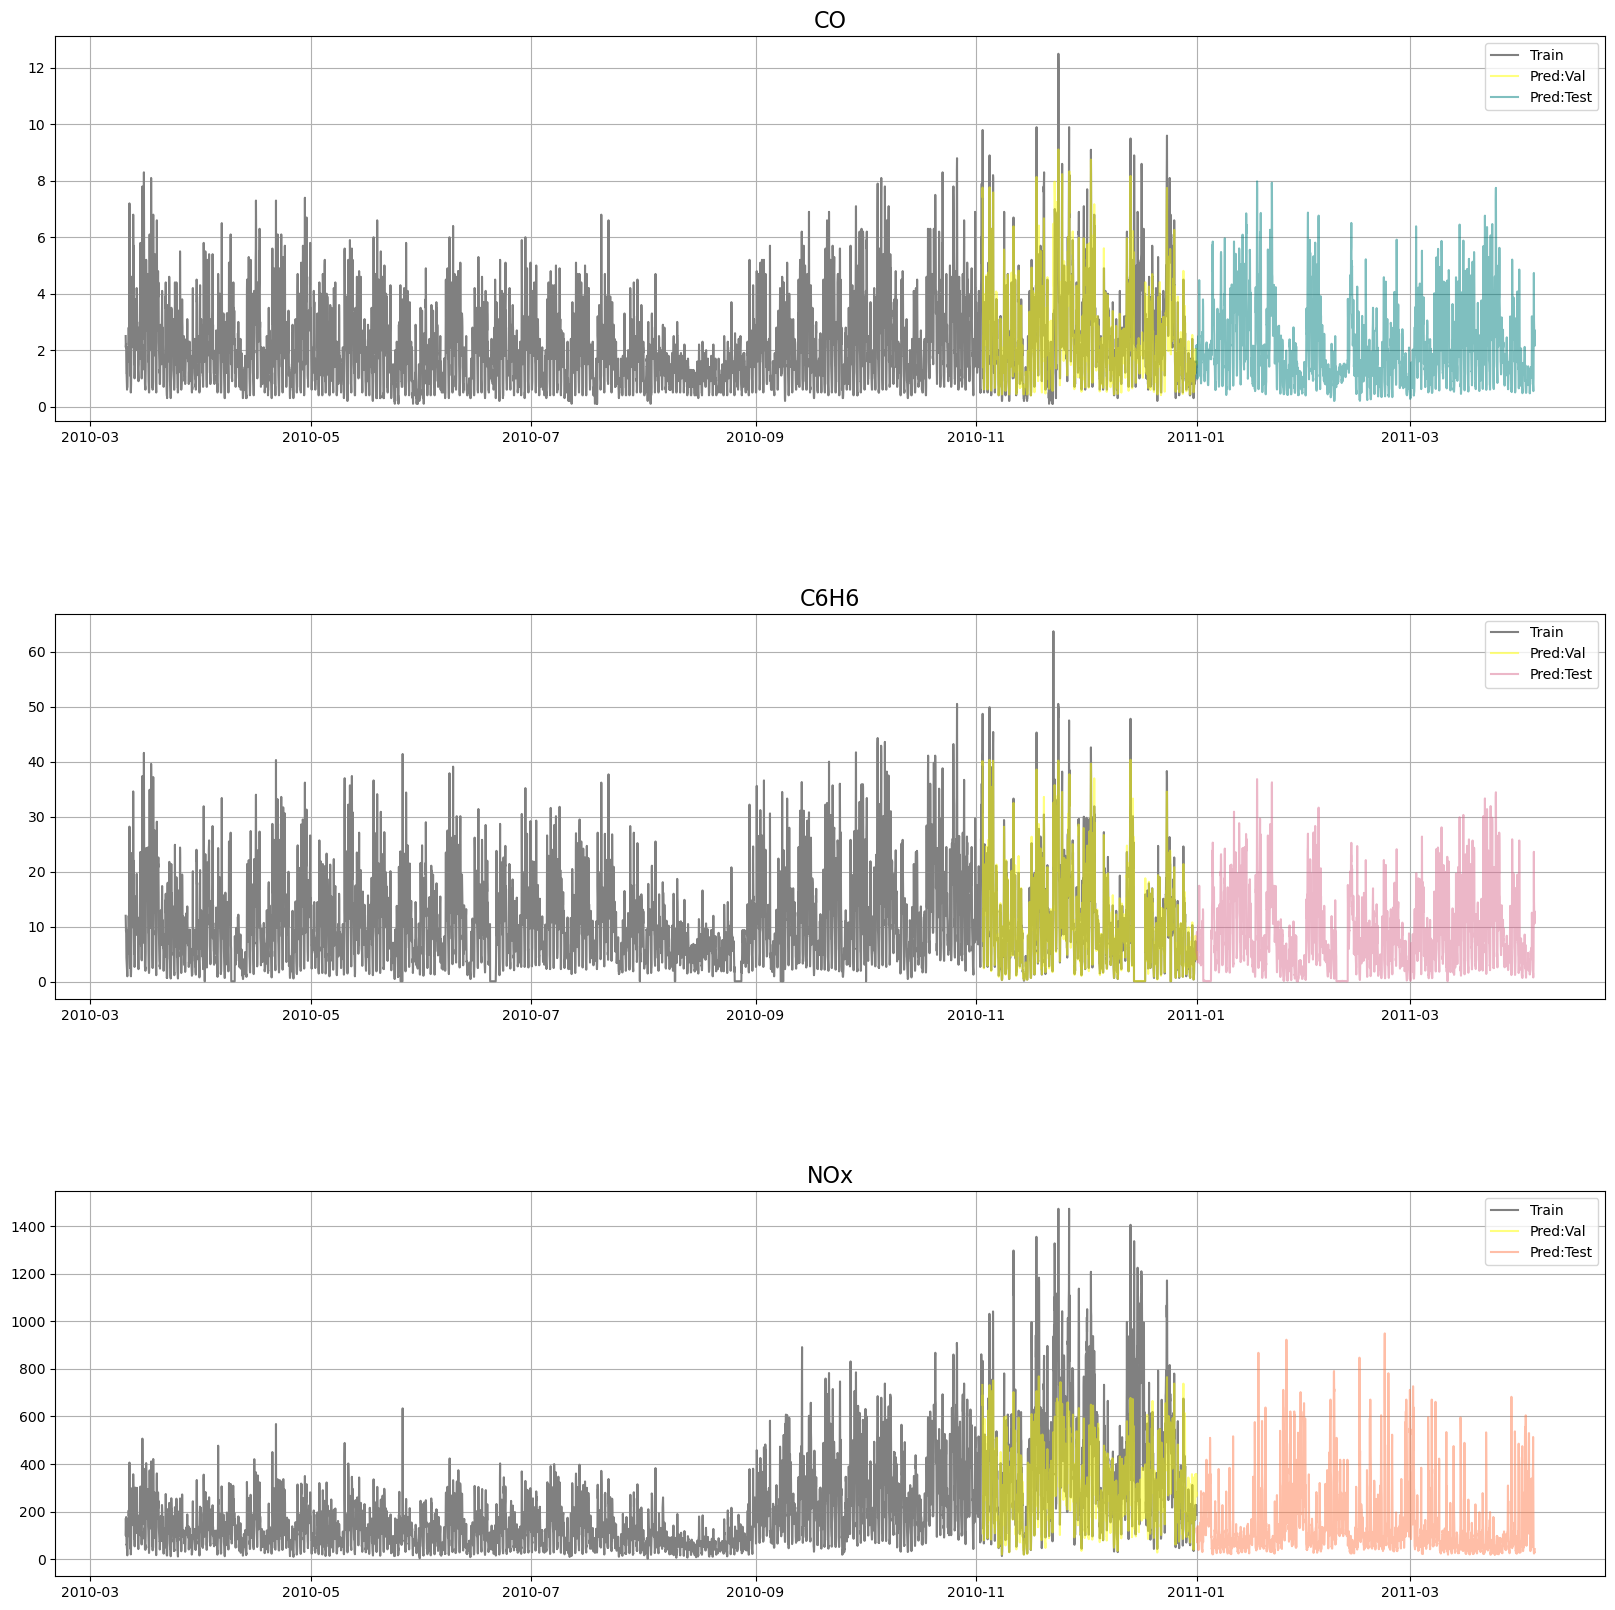

In [18]:
colors = ['teal', 'palevioletred', 'coral']
target_names = ['CO', 'C6H6', 'NOx']

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    name = f'val_lgb_{target_names[i]}'

    axs[i].plot(df_scaler['date_time'], np.expm1(df[targets[i]]), color='gray', label='Train')
    axs[i].plot(df_scaler_val['date_time'], np.expm1(globals()[name]), color='yellow', alpha=0.5, label='Pred:Val')
    axs[i].plot(test_with_pred['date_time'], test_with_pred[targets[i]], color=colors[i], alpha=0.5, label='Pred:Test')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].grid(axis='both')
    axs[i].legend(loc='upper right')

plt.show()


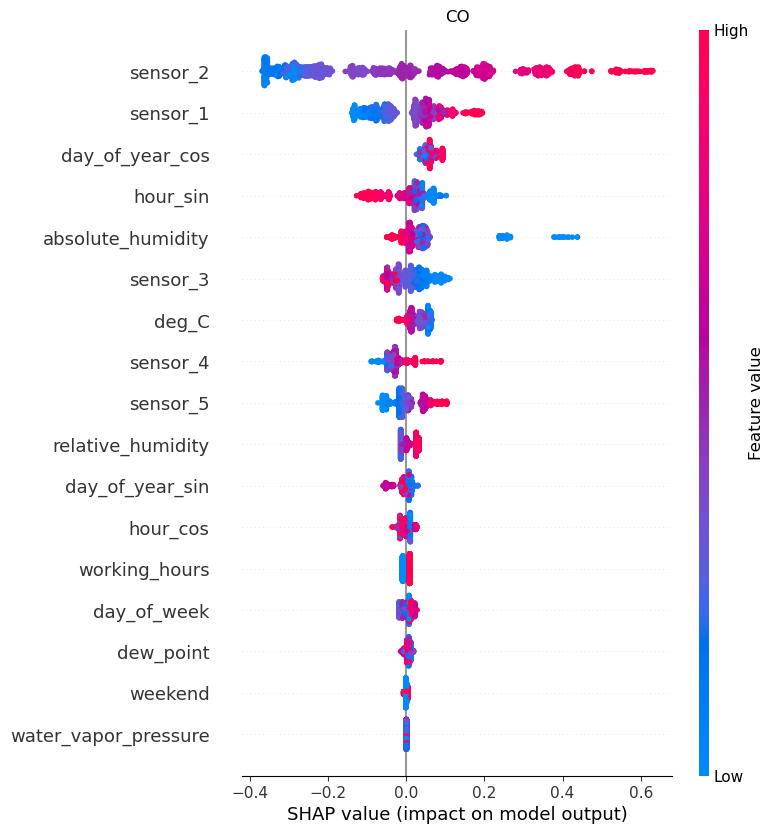

In [19]:
explainer_CO = shap.Explainer(model_lgb_CO)
shap_values_CO = explainer_CO(val_x_CO.reset_index(drop=True))

shap.summary_plot(shap_values_CO, val_x_CO, show=False)
plt.title('CO')
plt.show()

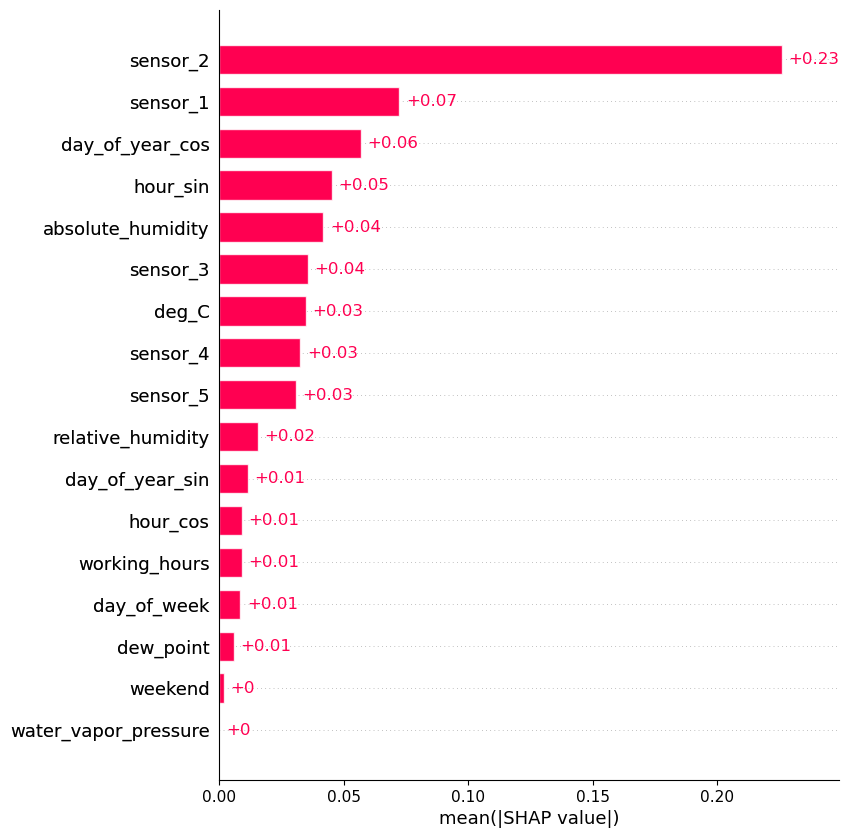

In [20]:
shap.plots.bar(shap_values_CO, max_display=20)
plt.show()

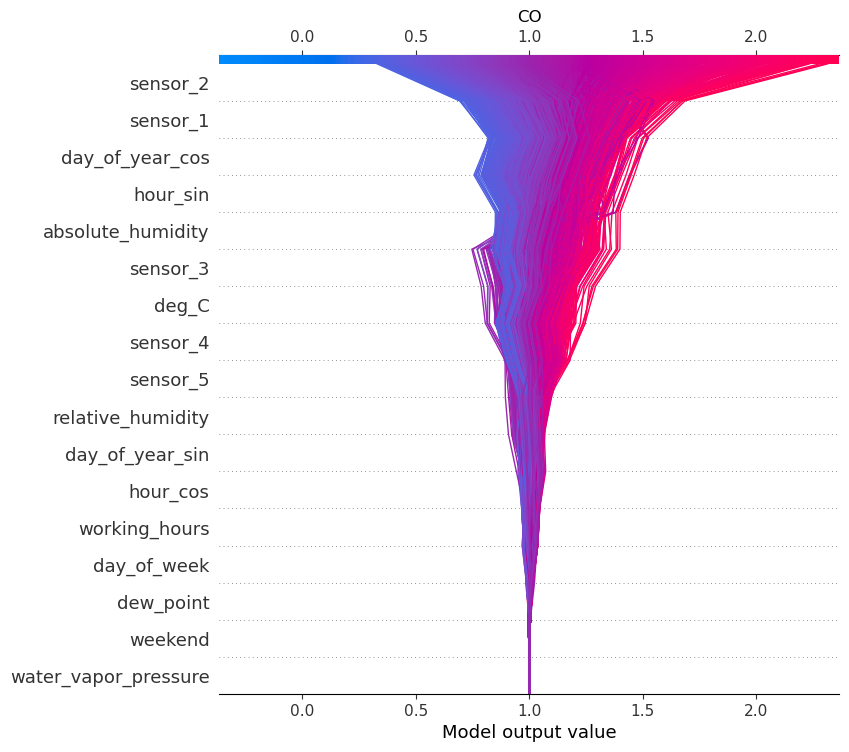

In [21]:
shap.decision_plot(explainer_CO.expected_value, explainer_CO.shap_values(val_x_CO), val_x_CO, show=False)
plt.title('CO')
plt.show()

In [22]:
shap.force_plot(shap_values_CO)

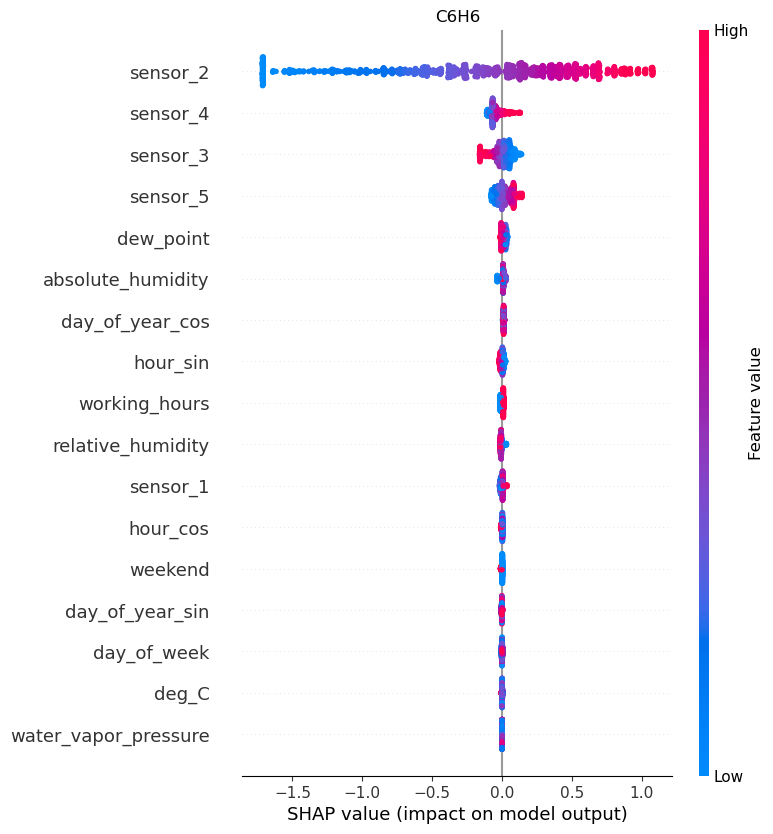

In [23]:
explainer_C6H6 = shap.Explainer(model_lgb_C6H6)
shap_values_C6H6 = explainer_C6H6(val_x_C6H6.reset_index(drop=True))

shap.summary_plot(shap_values_C6H6, val_x_C6H6, show=False)
plt.title('C6H6')
plt.show()

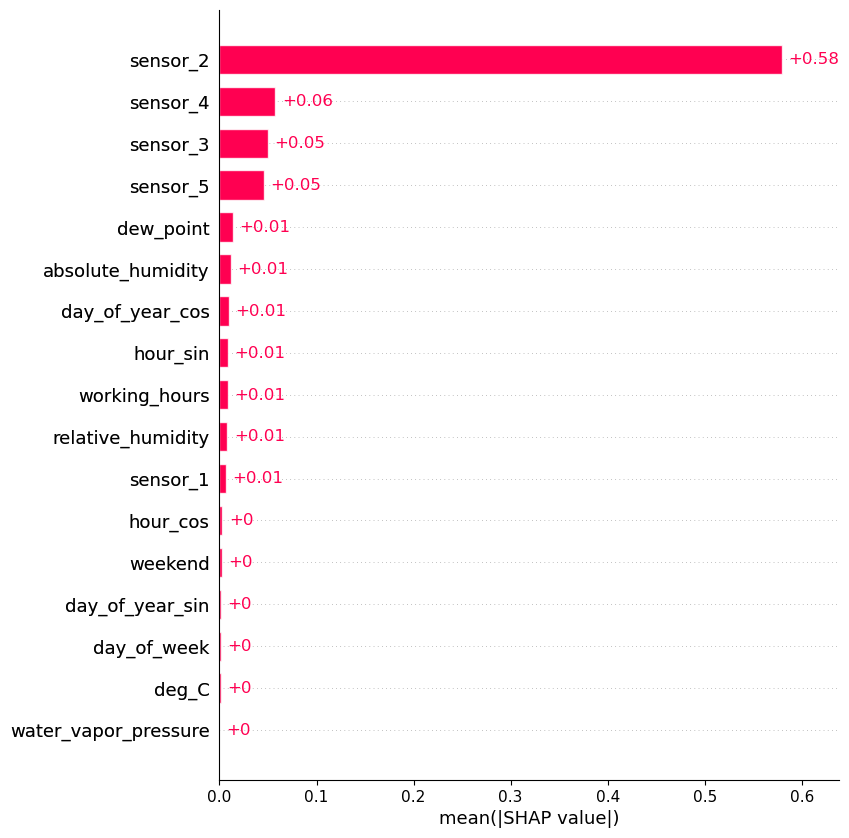

In [24]:
shap.plots.bar(shap_values_C6H6, max_display=20)
plt.show()

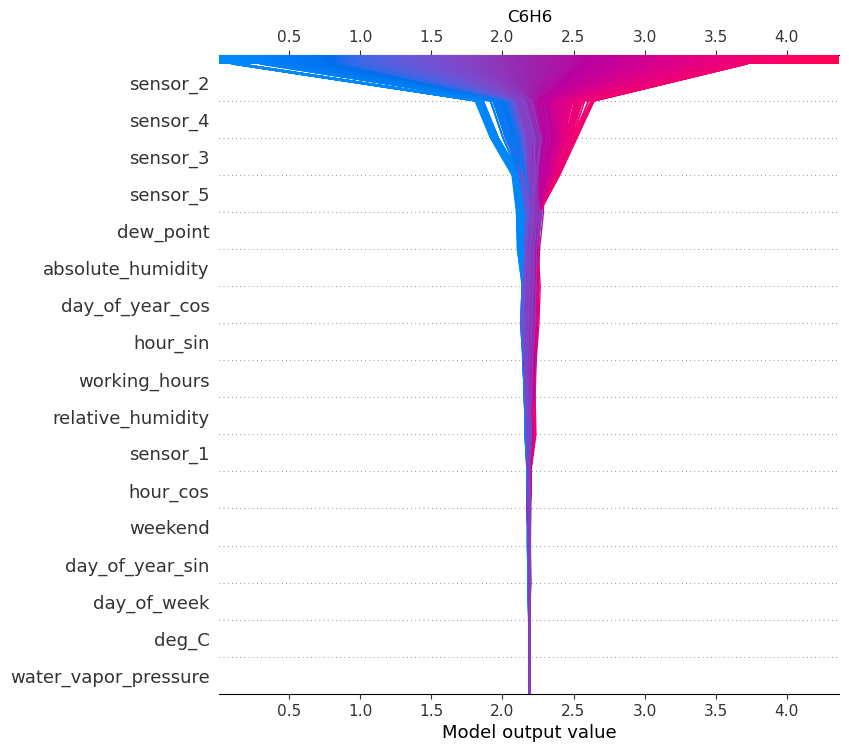

In [25]:
shap.decision_plot(explainer_C6H6.expected_value, explainer_C6H6.shap_values(val_x_C6H6), val_x_C6H6, show=False)
plt.title('C6H6')
plt.show()

In [26]:
shap.force_plot(shap_values_C6H6)

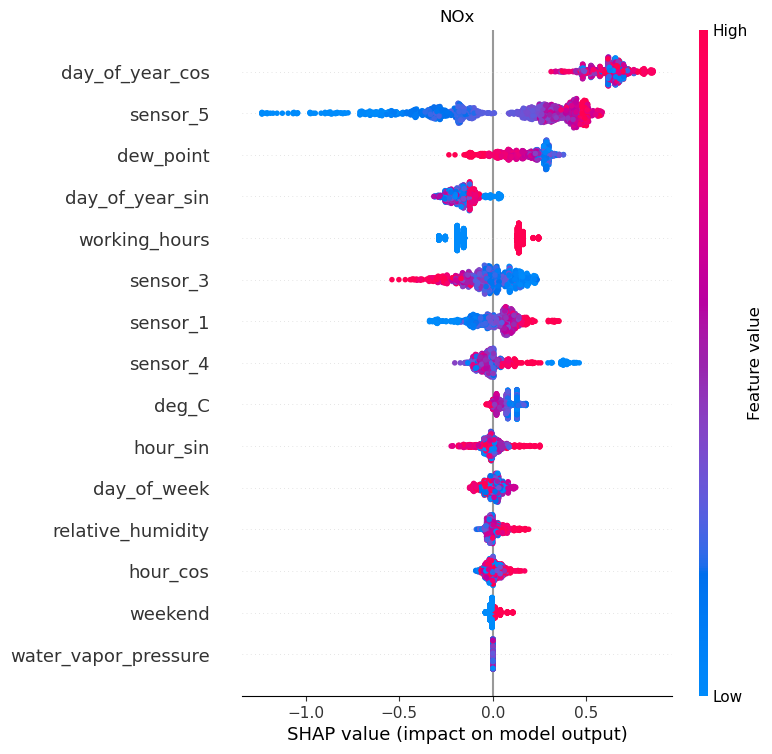

In [27]:
explainer_NOx = shap.Explainer(model_lgb_NOx)
shap_values_NOx = explainer_NOx(val_x_NOx.reset_index(drop=True))

shap.summary_plot(shap_values_NOx, val_x_NOx, show=False)
plt.title('NOx')
plt.show()

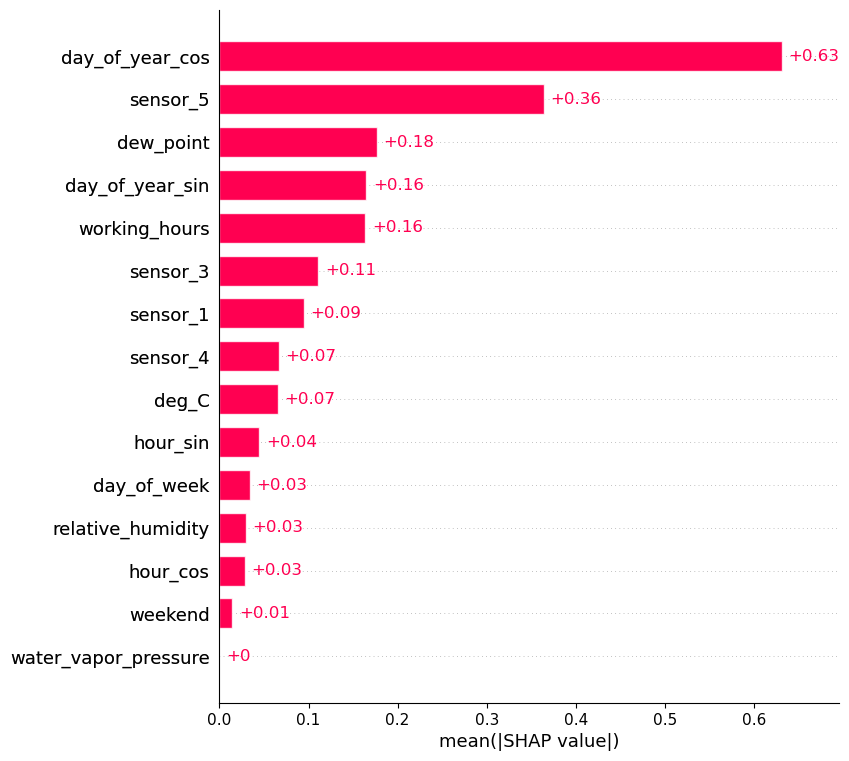

In [28]:
shap.plots.bar(shap_values_NOx, max_display=20)
plt.show()

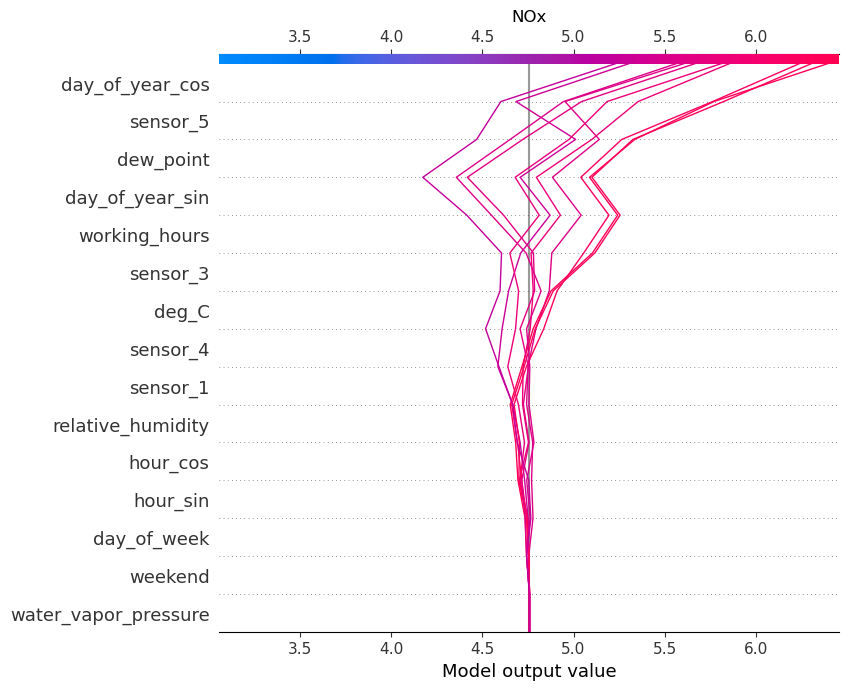

In [29]:
shap.decision_plot(explainer_NOx.expected_value, explainer_NOx.shap_values(val_x_NOx)[140:150], val_x_NOx, show=False)
plt.title('NOx')
plt.show()

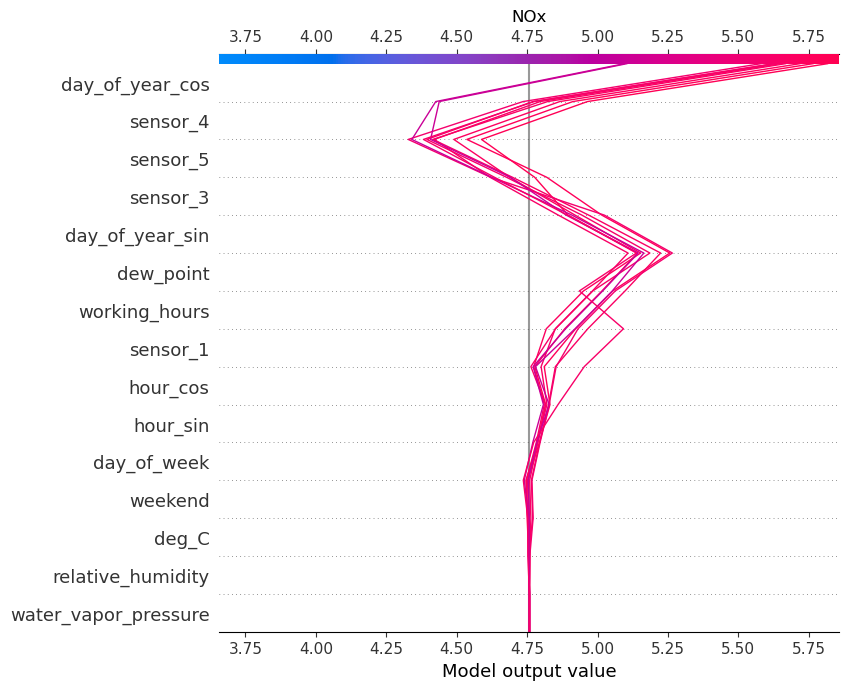

In [30]:
shap.decision_plot(explainer_NOx.expected_value, explainer_NOx.shap_values(val_x_NOx)[1050:1060], val_x_NOx, show=False)
plt.title('NOx')
plt.show()

In [31]:
shap.force_plot(shap_values_NOx)

### テストデータを全部学習させて最終結果を得る

In [32]:
df_train_y_CO = df[targets[0]]
df_train_x_CO = df.drop(targets, axis=1)

df_train_y_C6H6 = df[targets[1]]
df_train_x_C6H6 = df.drop(targets, axis=1)

df_train_y_NOx = df[targets[2]]
df_train_x_NOx = df.drop(targets, axis=1)

#df_test.set_index('date_time', inplace=True)


In [33]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(df_train_x_CO, df_train_y_CO)

model_lgb_CO_final = lgb.train(study_CO.best_trial.params, 
                    train_set=trains,
                    categorical_feature=categorical_features,
                    init_model=model_lgb_CO
                    )

pred_CO = np.expm1(model_lgb_CO_final.predict(df_test)).clip(min=0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3110
[LightGBM] [Info] Number of data points in the train set: 7111, number of used features: 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [34]:
# Oputunaで求めたパラメーターを使い、C6H6の値を予測
trains = lgb.Dataset(df_train_x_C6H6, df_train_y_C6H6)

model_lgb_C6H6_final = lgb.train(study_C6H6.best_trial.params, 
                    train_set=trains,
                    categorical_feature=categorical_features,
                    init_model=model_lgb_C6H6
                    )

pred_C6H6 = np.expm1(model_lgb_C6H6_final.predict(df_test)).clip(min=0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3110
[LightGBM] [Info] Number of data points in the train set: 7111, number of used features: 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [35]:
df_train_x_NOx = df_train_x_NOx.drop(['sensor_2', 'absolute_humidity'], axis=1)

In [36]:
# Oputunaで求めたパラメーターを使い、NOxの値を予測
trains = lgb.Dataset(df_train_x_NOx, df_train_y_NOx)

model_lgb_NOx_final = lgb.train(study_NOx.best_trial.params, 
                    train_set=trains,
                    categorical_feature=categorical_features,
                    init_model=model_lgb_NOx)

pred_NOx = np.expm1(model_lgb_NOx_final.predict(df_test, predict_disable_shape_check=True)).clip(min=0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 7111, number of used features: 15


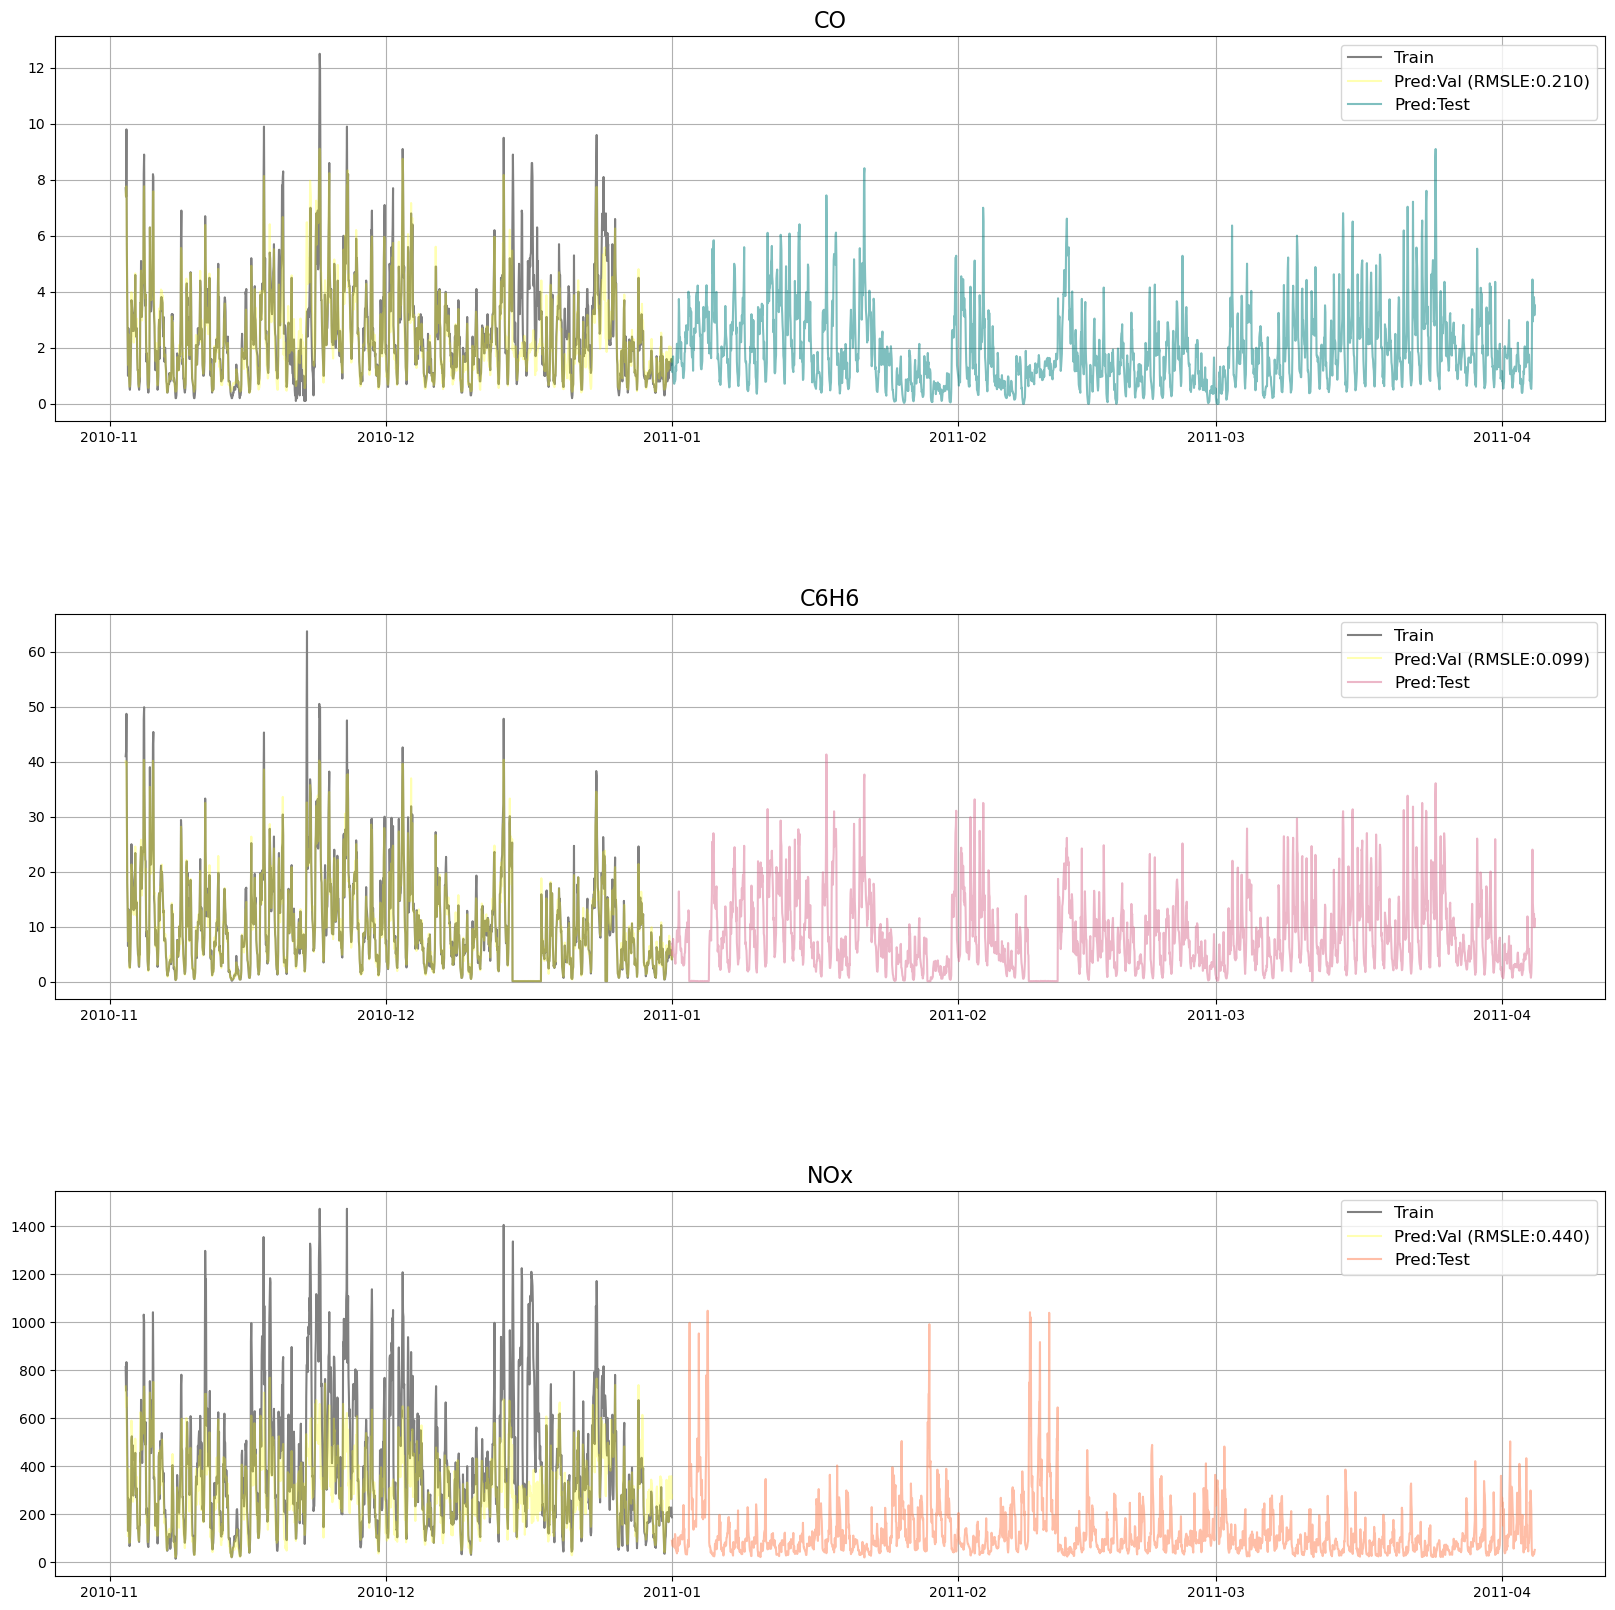

In [37]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    name1 = f'pred_{target_names[i]}'
    name2 = f'val_lgb_{target_names[i]}'
    name3 = f'rmsle_{target_names[i]}'

    axs[i].plot(df_scaler_val['date_time'], np.expm1(df_val[targets[i]]), color='gray', label='Train')
    axs[i].plot(df_scaler_val['date_time'], np.expm1(globals()[name2]), color='yellow', alpha=0.3, label=f'Pred:Val (RMSLE:{globals()[name3]:.3f})')
    axs[i].plot(df_test_scaler['date_time'], globals()[name1], color=colors[i], alpha=0.5, label='Pred:Test')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].grid(axis='both')
    axs[i].legend(loc='upper right', fontsize=12)

plt.show()

In [38]:
df_scaler_val = df_scaler_val.reset_index()

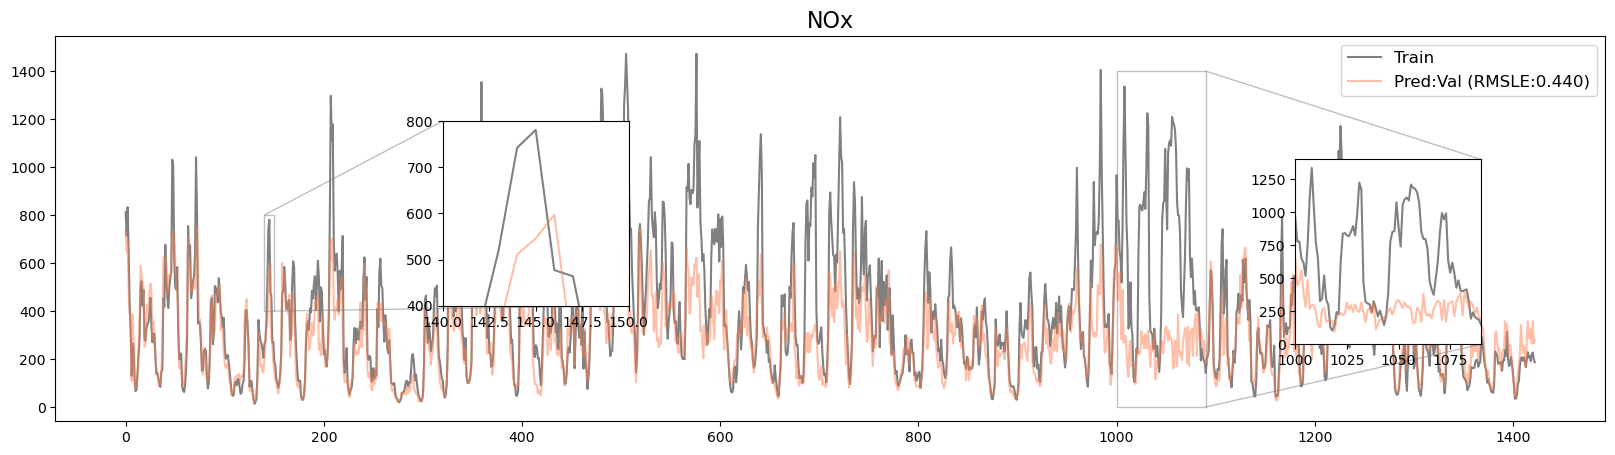

In [39]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=1, nrows=1)
plt.subplots_adjust(hspace = 0.5)

name1 = f'pred_{target_names[2]}'
name2 = f'val_lgb_{target_names[2]}'
name3 = f'rmsle_{target_names[2]}'

axs.plot(df_scaler_val.index, np.expm1(df_val[targets[i]]), color='gray', label='Train')
axs.plot(df_scaler_val.index, np.expm1(globals()[name2]), color=colors[2], alpha=0.5, label=f'Pred:Val (RMSLE:{globals()[name3]:.3f})')

axins1 = axs.inset_axes([0.25, 0.3, 0.12, 0.48])
axins1.plot(df_scaler_val.index, np.expm1(df_val[targets[i]]), color='gray')
axins1.plot(df_scaler_val.index, np.expm1(globals()[name2]), color=colors[2], alpha=0.5)
x11, x12, y11, y12 = 140, 150, 400, 800
axins1.set_xlim(x11, x12)
axins1.set_ylim(y11, y12)
axs.indicate_inset_zoom(axins1)

axins2 = axs.inset_axes([0.8, 0.2, 0.12, 0.48])
axins2.plot(df_scaler_val.index, np.expm1(df_val[targets[i]]), color='gray')
axins2.plot(df_scaler_val.index, np.expm1(globals()[name2]), color=colors[2], alpha=0.5)
x21, x22, y21, y22 = 1000, 1090, 0, 1400
axins2.set_xlim(x21, x22)
axins2.set_ylim(y21, y22)
axs.indicate_inset_zoom(axins2)

axs.set_title(f'{target_names[i]}', fontsize=16)
#axs.grid(axis='both')
axs.legend(loc='upper right', fontsize=12)

In [41]:
submit_base = pd.read_csv('sample_submission.csv')

submit = pd.DataFrame()

submit['date_time'] = submit_base['date_time']
submit[targets[0]] = pred_CO
submit[targets[1]] = pred_C6H6
submit[targets[2]] = pred_NOx

submit.to_csv('submission_lgbm_NOx_without_sensor2_abhum.csv', index=False)


### Kaggle score
    - Private: 0.28614
    - Public: 0.36329
    - 1144/1293